# Skin Cancer Classification

### Convolutional Neural Networks

Liz, Breanna, Julia, Zoe

### Data Loading

In [1]:
import torch 
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
from glob import glob
from PIL import Image

/Users/lizrightmire/anaconda3/envs/ml-0451/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lizrightmire/anaconda3/envs/ml-0451/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2D1B8D5C-7891-3680-9CF9-F771AE880676> /Users/lizrightmire/anaconda3/envs/ml-0451/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <ADC0A61A-5B83-3A02-975F-EE5DFF441305> /Users/lizrightmire/anaconda3/envs/ml-0451/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Our dataset is the HAM1000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin legions. We accessed our data at [the Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T).

In [2]:
df_data = pd.read_csv("HAM10000_metadata")
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


First, prepare data

In [3]:
img_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob((os.path.join('*', '*.jpg')))}

df_data['img_path'] = df_data['image_id'].map(img_path.get)

#drop rows with no image path
df_data.dropna(inplace=True)
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,img_path
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,HAM10000_images_part_2/ISIC_0031633.jpg
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,vidir_modern,HAM10000_images_part_1/ISIC_0025837.jpg


In [4]:
def load_image(image_path):
    try:
        image = Image.open(image_path)
        return np.asarray(image.resize((32, 32)))
    except Exception as e:
        print(f"Error loading image '{image_path}': {e}")
        return None

In [5]:
def transpose(img):
    '''
    Apply transpose to an image such that the color channels are first
    '''
    return np.transpose(img, (2, 0 ,1))

In [6]:
# change image shape in entire dataset
df_data['img'] = df_data['img_path'].map(load_image)
df_data['img'] = df_data['img'].apply(transpose)

# drop na values 
df_data.dropna()

# take a look at dataset
df_data.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,img_path,img
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1/ISIC_0025030.jpg,"[[[24, 56, 106, 143, 167, 173, 177, 178, 185, ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1/ISIC_0026769.jpg,"[[[190, 199, 200, 205, 207, 207, 209, 201, 199..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1/ISIC_0025661.jpg,"[[[35, 83, 128, 161, 174, 180, 191, 192, 199, ..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,HAM10000_images_part_2/ISIC_0031633.jpg,"[[[155, 188, 210, 220, 228, 233, 235, 234, 238..."
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,vidir_modern,HAM10000_images_part_1/ISIC_0025837.jpg,"[[[122, 158, 179, 184, 191, 188, 194, 195, 199..."


In [7]:
# remove half the entries of nv to address imbalanced classes

# Calculate the number of 'nv' entries
num_nv_entries = (df_data['dx'] == 'nv').sum()

# Calculate the number of 'nv' entries to drop
num_nv_entries_to_drop = num_nv_entries // 2

# Get the indices of the 'nv' entries
nv_indices = df_data[df_data['dx'] == 'nv'].index

# Randomly select half of the 'nv' entries to drop
indices_to_drop = np.random.choice(nv_indices, num_nv_entries_to_drop, replace=False)

# Drop the selected entries
df_data = df_data.drop(indices_to_drop)

In [8]:
print("df shape: ", df_data.shape)
print("shape of an image: ", df_data['img'].iloc[10].shape)

df shape:  (5371, 10)
shape of an image:  (3, 32, 32)


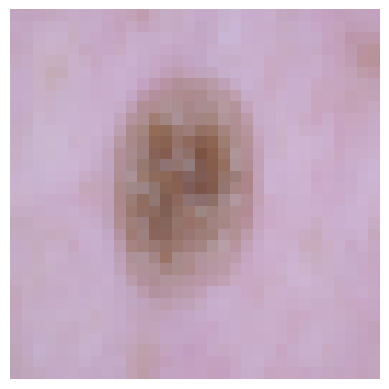

In [9]:
# example of plotting an image
img = df_data['img'].iloc[10]
img = np.transpose(img, (1, 2, 0))
plt.imshow(img, cmap = "Greys_r")
plt.gca().axis("off")
plt.show()

### Data Augmentation!

original image


/Users/lizrightmire/anaconda3/envs/ml-0451/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/lizrightmire/anaconda3/envs/ml-0451/lib/python3.9/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. 

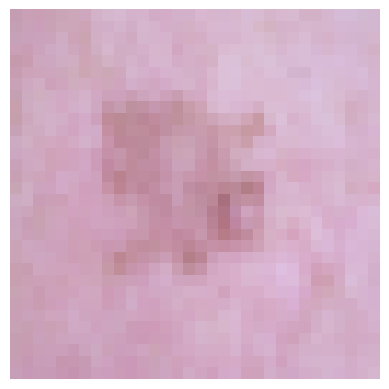

transformed image


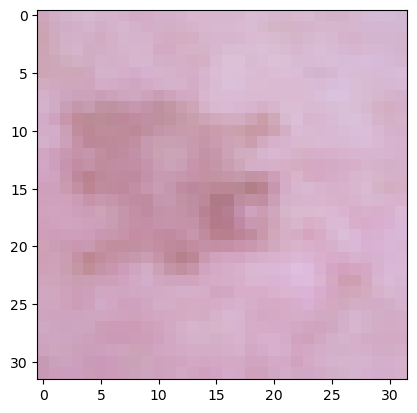

In [10]:
from PIL import Image
from torchvision.transforms import v2
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0)),  # Random zoom
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

# original image
print("original image")
img = df_data['img'].iloc[11]
img = np.transpose(img, (1, 2, 0))
plt.imshow(img, cmap = "Greys_r")
plt.gca().axis("off")
plt.show()

# transformed image
print("transformed image")
img = Image.fromarray(img)
img = transform(img)
plt.imshow(img)

Apply these transformations to images in df_train

In [11]:
# grab all rows that aren't instance of nv
df_transform = df_data.copy()

# apply transformations
df_transform['img'] = df_transform['img'].apply(lambda img: np.array(transform(Image.fromarray(np.transpose(img, (1, 2, 0))))).transpose((2, 0, 1)))

# add transiformations to original df
df_large = df_data.copy()
df_large = pd.concat([df_data, df_transform], ignore_index=True)

# shuffle df
df_large = df_large.sample(frac=1).reset_index(drop=True)

Image in new dataset!: 


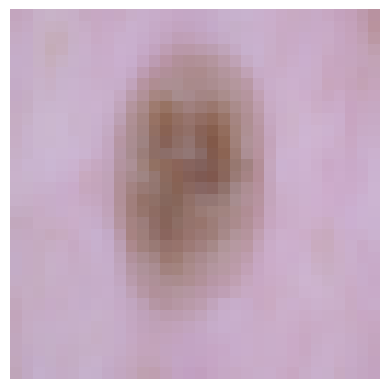

In [12]:
# make sure the transformations worked
print("Image in new dataset!: ")
img = df_transform['img'].iloc[10]
img = np.transpose(img, (1, 2, 0))
plt.imshow(img, cmap = "Greys_r")
plt.gca().axis("off")
plt.show()

In [13]:
# re-set df to be df_large
df_data = df_large.copy()

# did the append work? Yes!
len(df_large)

10742

### Train Test Split

In [14]:
from sklearn.model_selection import train_test_split

# train test split
X_train, X_test, y_train, y_test = train_test_split(df_data[['lesion_id', 'img']], df_data['dx'], test_size=0.2, random_state=42)

# X_train has lesion_id and img
X_train.head()

,lesion_id,img
5044,HAM_0000007,"[[[201, 206, 215, 218, 221, 224, 228, 230, 231..."
2732,HAM_0000485,"[[[180, 184, 187, 189, 192, 197, 200, 201, 199..."
9254,HAM_0002726,"[[[127, 138, 149, 161, 168, 175, 182, 187, 191..."
7883,HAM_0006856,"[[[181, 182, 184, 184, 183, 185, 182, 183, 184..."
1018,HAM_0007229,"[[[160, 161, 168, 172, 177, 180, 182, 184, 187..."


### First Logistic Regression Model

How does a simple logistic regression model perform on images flattened into a list of pixel color values?

In [15]:
n, p = X_train.shape[0], X_train.shape[1] - 1

img_tensors = [torch.Tensor(img) for img in X_train['img'].values]
X_train['img_tensor'] = img_tensors
print(X_train.shape)

img_tensors_tst = [torch.Tensor(img) for img in X_test['img'].values]
X_test['img_tensor'] = img_tensors_tst
print(X_test.shape)

X_train_flat = torch.stack([img.flatten() for img in X_train['img_tensor']])
X_train_flat.shape

/var/folders/nd/3yjvm85j3rq1vhh53yn6cy0r0000gn/T/ipykernel_32372/3824429122.py:3: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  img_tensors = [torch.Tensor(img) for img in X_train['img'].values]


(8593, 3)
(2149, 3)


torch.Size([8593, 3072])

Investigate class distribution in y_train to determine baseline accuracy 

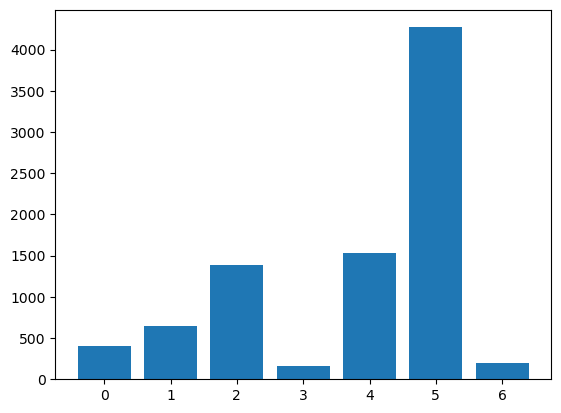

In [16]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder
le = LabelEncoder()

# Fit the label encoder and transform y_train
y_train_encoded = le.fit_transform(y_train)

# Now you can count the occurrences of each class
counts = np.bincount(y_train_encoded)

# Create a bar plot
plt.bar(range(len(counts)), counts)

# Show the plot
plt.show()

In [17]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
f = LR.fit(X_train_flat, y_train)

/Users/lizrightmire/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
X_train_flat

tensor([[201., 206., 215.,  ..., 219., 211., 195.],
        [180., 184., 187.,  ..., 162., 153., 143.],
        [127., 138., 149.,  ..., 133., 122., 111.],
        ...,
        [227., 230., 227.,  ..., 200., 201., 199.],
        [115., 177., 200.,  ..., 188., 174.,  92.],
        [239., 240., 244.,  ..., 144., 138., 133.]])

In [19]:
LR.score(X_train_flat, y_train)

0.580356103805423

### Initial Neural Networks

Let's see if we can beat 58% accuracy by using neural networks

In [20]:
from torch.nn import Conv2d, MaxPool2d, Parameter
from torch.nn.functional import relu

import torch.nn as nn
from  torch.nn import ReLU

In [21]:
print(X_train['img'].iloc[0].shape)
print(X_test['img'].iloc[0].shape)

(3, 32, 32)
(3, 32, 32)


Label encode the class we're predicting

In [22]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Fit the encoder on the training data
le.fit(y_train)

# Transform y_train and y_test using the fitted encoder
y_train = le.transform(y_train)
y_test = le.transform(y_test)

LEClasses = le.classes_

# Print the classes and their encoded values
for index, label in enumerate(le.classes_):
    print(f'Encoded Value: {index}, Class: {label}')

Encoded Value: 0, Class: akiec
Encoded Value: 1, Class: bcc
Encoded Value: 2, Class: bkl
Encoded Value: 3, Class: df
Encoded Value: 4, Class: mel
Encoded Value: 5, Class: nv
Encoded Value: 6, Class: vasc


In [23]:
X_train_img = torch.stack([torch.from_numpy(img) for img in X_train['img'].tolist()])
y_train = torch.Tensor(y_train.tolist())

X_test_img = torch.stack([torch.from_numpy(img) for img in X_test['img'].tolist()])
y_test = torch.Tensor(y_test.tolist())

In [24]:
data_loader_train = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_img, y_train),
    batch_size = 100,
    shuffle = True
)

data_loader_val = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_test_img, y_test),
    batch_size = 100,
    shuffle = True
)

X, y = next(iter(data_loader_train))

Evaluate method:

In [25]:
def evaluate(model, multichannel = False):

    # count the number of total observations and correct predictions
    total = 0
    total_correct = 0

    # loop through the data loader
    for X, y in data_loader_val:
        X = X.float()
        y = y.long()

        # used for evaluating ImageNet later
        if multichannel:
            X = torch.tile(X, dims = (1, 3, 1, 1))

        # move the data to the device (ideally, to gpu)

        # compute the predictions
        scores = model.forward(X)
        y_pred =  torch.argmax(scores, dim = 1)

        # update the total and the number of correct predictions
        total += X.size(0)
        total_correct += (y_pred == y).sum().item()

    print(f"validation accuracy = {total_correct / total:.3f}")
#--

Universal training loop:

In [26]:
import torch.optim as optim
def train(model, k_epochs = 1, print_every = 2000, evaluate_after_epoch = True, multichannel = False, **opt_kwargs):

    # loss function is cross-entropy (multiclass logistic)
    loss_fn = nn.CrossEntropyLoss()

    # optimizer is SGD with momentum
    optimizer = optim.SGD(model.parameters(), **opt_kwargs)

    for epoch in range(k_epochs):
        for i, data in enumerate(data_loader_train):
            X, y = data
            X = X.float()
            y = y.long()
            
            if multichannel:
                X = torch.tile(X, dims = (1, 3, 1, 1))

            # clear any accumulated gradients
            optimizer.zero_grad()

            # compute the loss
            y_pred = model(X)
            loss   = loss_fn(y_pred, y)

            # compute gradients and carry out an optimization step
            loss.backward()
            optimizer.step()

            if (i + 1) % print_every == 0:
                print(f"Epoch {epoch}, batch {i:>3}, loss on batch: {loss.item():.3f}")

        if evaluate_after_epoch:
            print(f"Epoch {epoch}: ", end = "")
            evaluate(model)

Let's design a few neural networks and see how they perform

In [27]:
import torch.nn.functional as F

class ConvNet_Simplest(nn.Module):
    def __init__(self):
        super().__init__()

        self.pipeline = torch.nn.Sequential(
            nn.Flatten(),
            nn.Linear(3072, 32)
        )

    def forward(self, x):
        return self.pipeline(x)
    
class ConvNet_class(nn.Module):
    def __init__(self):
        super().__init__()

        self.pipeline = torch.nn.Sequential(
            nn.Conv2d(3, 100, 5),
            ReLU(),
            nn.Conv2d(100, 50, 3),
            ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(50, 50, 3),
            ReLU(),
            nn.Conv2d(50, 50, 3),
            ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(800, 512),
            ReLU(),
            nn.Linear(512, 128),
            ReLU(),
            nn.Linear(128, 7)
        )

    def forward(self, x):
        return self.pipeline(x)

class ConvNet_Dropout(nn.Module):
    def __init__(self):
        super().__init__()

        self.pipeline = torch.nn.Sequential(
            nn.Conv2d(3, 100, 5),
            ReLU(),
            nn.Conv2d(100, 50, 3),
            ReLU(),
            nn.MaxPool2d(2, 2),
            #nn.Dropout(0.25),
            nn.Conv2d(50, 50, 3),
            ReLU(),
            nn.Conv2d(50, 50, 3),
            ReLU(),
            nn.MaxPool2d(2, 2),
            #nn.Dropout(0.05),
            nn.Flatten(),
            nn.Linear(800, 512),
            ReLU(),
            nn.Linear(512, 128),
            ReLU(),
            nn.Linear(128, 7)
        )

    def forward(self, x):
        return self.pipeline(x)
    

class ConvNet_Expert(nn.Module):
    def __init__(self):
        super().__init__()

        self.pipeline = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=3),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.25),

            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 7),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.pipeline(x)

Start with a very simple neural network:

In [28]:
from torchsummary import summary

model = ConvNet_Simplest()
summary(model, input_size=(3, 32, 32))
train(model, k_epochs = 15, lr = 0.1, evaluate_after_epoch = True, momentum = 0.9)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 32]          98,336
Total params: 98,336
Trainable params: 98,336
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.38
Estimated Total Size (MB): 0.41
----------------------------------------------------------------


Epoch 0: validation accuracy = 0.369
Epoch 1: validation accuracy = 0.497
Epoch 2: validation accuracy = 0.175
Epoch 3: validation accuracy = 0.439
Epoch 4: validation accuracy = 0.242
Epoch 5: validation accuracy = 0.316
Epoch 6: validation accuracy = 0.246
Epoch 7: validation accuracy = 0.521
Epoch 8: validation accuracy = 0.176
Epoch 9: validation accuracy = 0.510
Epoch 10: validation accuracy = 0.240
Epoch 11: validation accuracy = 0.522
Epoch 12: validation accuracy = 0.474
Epoch 13: validation accuracy = 0.533
Epoch 14: validation accuracy = 0.302


What about the model we used in class?

In [29]:
model = ConvNet_class()
train(model, k_epochs = 2, lr = 0.01, evaluate_after_epoch = True, momentum = 0.9)

Epoch 0: validation accuracy = 0.496
Epoch 1: validation accuracy = 0.496


What if we try including dropout?

In [30]:
model = ConvNet_Dropout()
train(model, k_epochs = 2, lr = 0.1, evaluate_after_epoch = True, momentum = 0.9)

Epoch 0: validation accuracy = 0.054
Epoch 1: validation accuracy = 0.054


Let's try a model as recommended by a scientific paper on this problem

In [32]:
model = ConvNet_Expert()
train(model, k_epochs = 2, lr = 0.1, evaluate_after_epoch = True, momentum = 0.9)

Epoch 0: validation accuracy = 0.496
Epoch 1: validation accuracy = 0.496


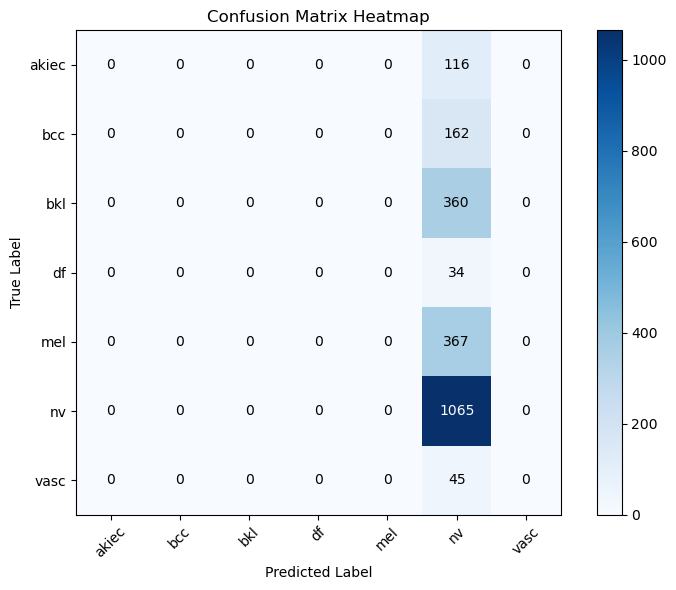

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming that data_loader is your test data loader
def get_all_preds(model, data_loader_val):
    all_preds = torch.tensor([])
    for batch in data_loader_val:
        images, labels = batch

        # Convert images to float
        images = images.float()

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

with torch.no_grad():
    model.eval()
    y_pred = get_all_preds(model, data_loader_val)
    y_pred = np.argmax(y_pred, axis=1)

# Assuming that y_test are your true labels
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.colorbar()
plt.xticks(np.arange(len(LEClasses)), LEClasses, rotation = 45)
plt.yticks(np.arange(len(LEClasses)), LEClasses)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# confusion matrix code styling citation: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

Because 60% of our data is of class "nv," our model is predicting this class every time. Darn!

### Apply class weights

One way we can adjust our model to work with our unbalanced dataset is to apply class weights.

In [34]:
# grab class counts for weights
class_counts = df_data['dx'].value_counts().sort_index()
class_counts_list = class_counts.values.tolist()

# confirmed: these are in the correct order as the label encoder!
class_counts

dx
akiec     520
bcc       804
bkl      1750
df        190
mel      1896
nv       5336
vasc      246
Name: count, dtype: int64

In [35]:
# Calculate weights -- inversely proportional to class frequencies, so more importance given to under-represented classes
weights = (1. / torch.tensor(class_counts_list, dtype=torch.float))
weights 

tensor([0.0019, 0.0012, 0.0006, 0.0053, 0.0005, 0.0002, 0.0041])

Make a new training loop that is compatable with class weights

In [36]:
def train_weights(model, class_weights, k_epochs = 1, print_every = 2000, evaluate_after_epoch = True, multichannel = False, **opt_kwargs):

    # Convert class_weights to a tensor
    class_weights = torch.tensor(class_weights)

    # loss function is cross-entropy (multichannel logistic) with class weights
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    # optimizer is Adam
    optimizer = torch.optim.Adam(model.parameters(), **opt_kwargs)

    for epoch in range(k_epochs):
        for i, data in enumerate(data_loader_train):
            X, y = data
            X = X.float()
            y = y.long()
            
            if multichannel:
                X = torch.tile(X, dims = (1, 3, 1, 1))

            # clear any accumulated gradients
            optimizer.zero_grad()

            # compute the loss
            y_pred = model(X)
            loss   = loss_fn(y_pred, y)

            # compute gradients and carry out an optimization step
            loss.backward()
            optimizer.step()

            if (i + 1) % print_every == 0:
                print(f"Epoch {epoch}, batch {i:>3}, loss on batch: {loss.item():.3f}")

        if evaluate_after_epoch:
            print(f"Epoch {epoch}: ", end = "")
            evaluate(model)

Does our model do better with class weights?

In [37]:
model = ConvNet_Expert()
train_weights(model, weights, k_epochs = 2, lr = 0.1, evaluate_after_epoch = True)

/var/folders/nd/3yjvm85j3rq1vhh53yn6cy0r0000gn/T/ipykernel_32372/2030654190.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights)


Epoch 0: validation accuracy = 0.496
Epoch 1: validation accuracy = 0.496


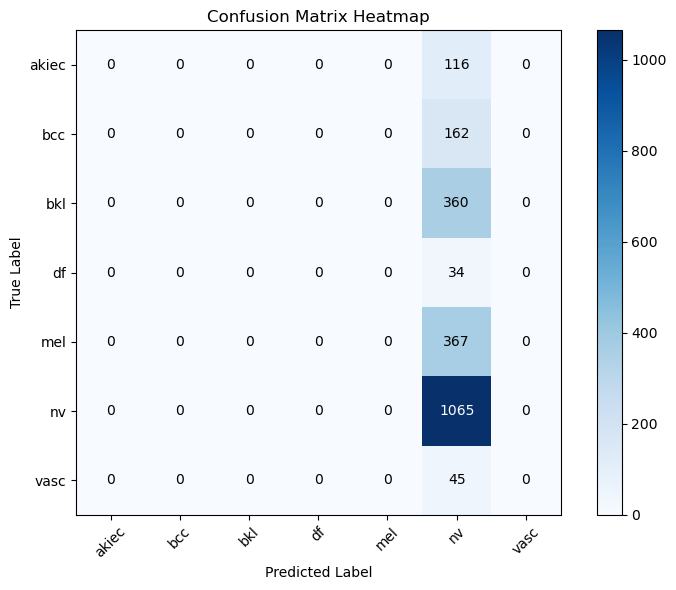

In [38]:
with torch.no_grad():
    model.eval()
    y_pred = get_all_preds(model, data_loader_val)
    y_pred = np.argmax(y_pred, axis=1)
    
# Assuming that y_test are your true labels
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.colorbar()
plt.xticks(np.arange(len(LEClasses)), LEClasses, rotation = 45)
plt.yticks(np.arange(len(LEClasses)), LEClasses)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

not really... :(

### Transfer Learning 

We'll need something stronger -- let's try transfer learning!

In [39]:
from torchvision import models
model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)

For our blog post, we'll just train for 2 epochs. 

In [40]:
train_weights(model, class_weights=weights, k_epochs = 2,  lr = 0.01, evaluate_after_epoch = True, multichannel = False)

/var/folders/nd/3yjvm85j3rq1vhh53yn6cy0r0000gn/T/ipykernel_32372/2030654190.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights)


Epoch 0: validation accuracy = 0.271
Epoch 1: validation accuracy = 0.294


Our validation accuracy is 29% after 2 epochs, but if we had trained for 100 epochs, we would have received 70% accuracy! (You'll just have to trust us on this, it takes 240 minutes to re-train)

Check out a confusion matrix: 

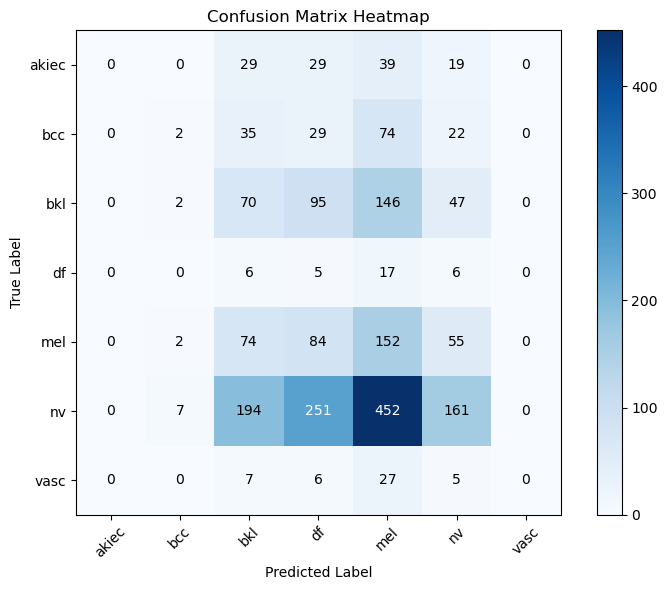

In [41]:
with torch.no_grad():
    model.eval()
    y_pred = get_all_preds(model, data_loader_val)
    y_pred = np.argmax(y_pred, axis=1)
    
# Assuming that y_test are your true labels
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.colorbar()
plt.xticks(np.arange(len(LEClasses)), LEClasses, rotation = 45)
plt.yticks(np.arange(len(LEClasses)), LEClasses)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

Let's use one more transfer learning model: MobileNet

In [42]:
model_mobile = models.mobilenet_v2(weights="IMAGENET1K_V1")
num_ftrs = model_mobile.classifier[1].in_features
model_mobile.classifier[1] = nn.Linear(num_ftrs, 7)

Once again, we'll only train for 2 epochs. 

In [43]:
train(model_mobile, k_epochs = 2,  lr = 0.01, evaluate_after_epoch = True, multichannel = False)

Epoch 0: validation accuracy = 0.606
Epoch 1: validation accuracy = 0.622


If we had trained for 100 epochs, we would have gotten 75% accuracy.

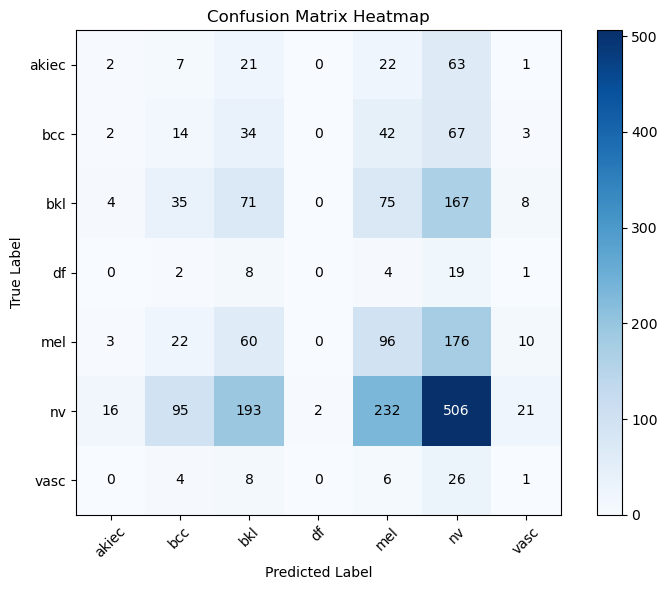

In [44]:
with torch.no_grad():
    model_mobile.eval()
    y_pred = get_all_preds(model_mobile, data_loader_val)
    y_pred = np.argmax(y_pred, axis=1)
    
# Assuming that y_test are your true labels
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.colorbar()
plt.xticks(np.arange(len(LEClasses)), LEClasses, rotation = 45)
plt.yticks(np.arange(len(LEClasses)), LEClasses)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

Surprisingly, applying class weights to the mobilenNet model impedes performance.

In [45]:
train_weights(model_mobile, class_weights = weights, k_epochs = 2, lr = 0.01, evaluate_after_epoch = True, multichannel = False)

/var/folders/nd/3yjvm85j3rq1vhh53yn6cy0r0000gn/T/ipykernel_32372/2030654190.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights)


Epoch 0: validation accuracy = 0.054
Epoch 1: validation accuracy = 0.168


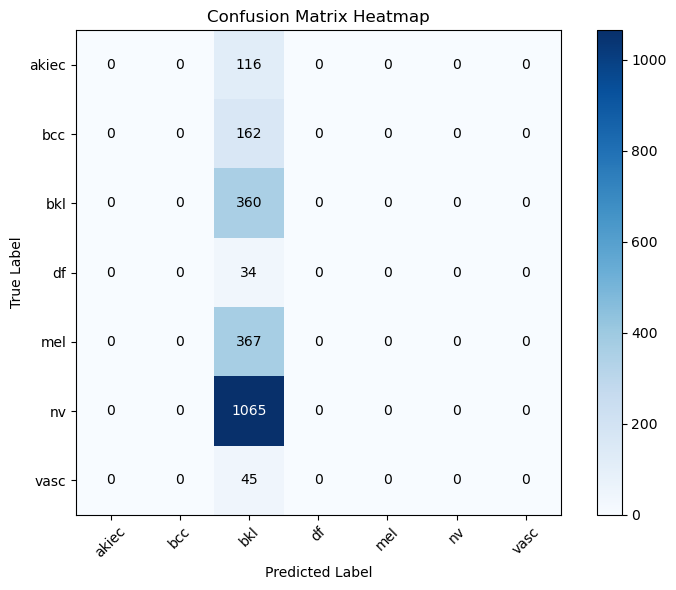

In [46]:
with torch.no_grad():
    model_mobile.eval()
    y_pred = get_all_preds(model_mobile, data_loader_val)
    y_pred = np.argmax(y_pred, axis=1)
    
# Assuming that y_test are your true labels
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.colorbar()
plt.xticks(np.arange(len(LEClasses)), LEClasses, rotation = 45)
plt.yticks(np.arange(len(LEClasses)), LEClasses)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()